Find exposures of a single night

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }

fringe_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'

In [4]:
# ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']
# ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z'
ccd = ccd[mask]
print(len(ccd))

1148265


5002


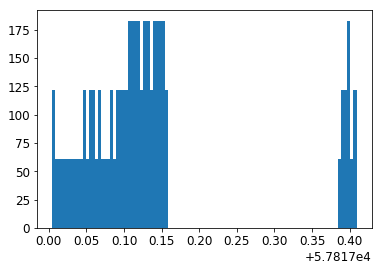

In [5]:
mask = np.char.find(np.array(ccd['image_filename'], dtype='str'), 'CP20170304')!=-1
print(np.sum(mask))

ccd1 = ccd[mask].copy()
# plt.hist(ccd1['mjd_obs'], 100, range=(ccd1['mjd_obs'].min(), ccd1['mjd_obs'].max()));

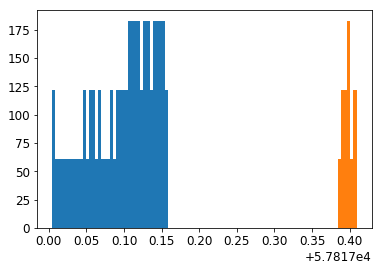

4331


In [6]:
# Remove the dawn frames
mjd_sort = np.sort(ccd1['mjd_obs'])
mdj_sep = (mjd_sort[1:] - mjd_sort[:-1])
mask = ccd1['mjd_obs']<=mjd_sort[np.argmax(mdj_sep)]

plt.hist(ccd1['mjd_obs'][mask], 100, range=(ccd1['mjd_obs'].min(), ccd1['mjd_obs'].max()))
plt.hist(ccd1['mjd_obs'][~mask], 100, range=(ccd1['mjd_obs'].min(), ccd1['mjd_obs'].max()))
plt.show()

ccd1 = ccd1[mask]
print(len(ccd1))

574132


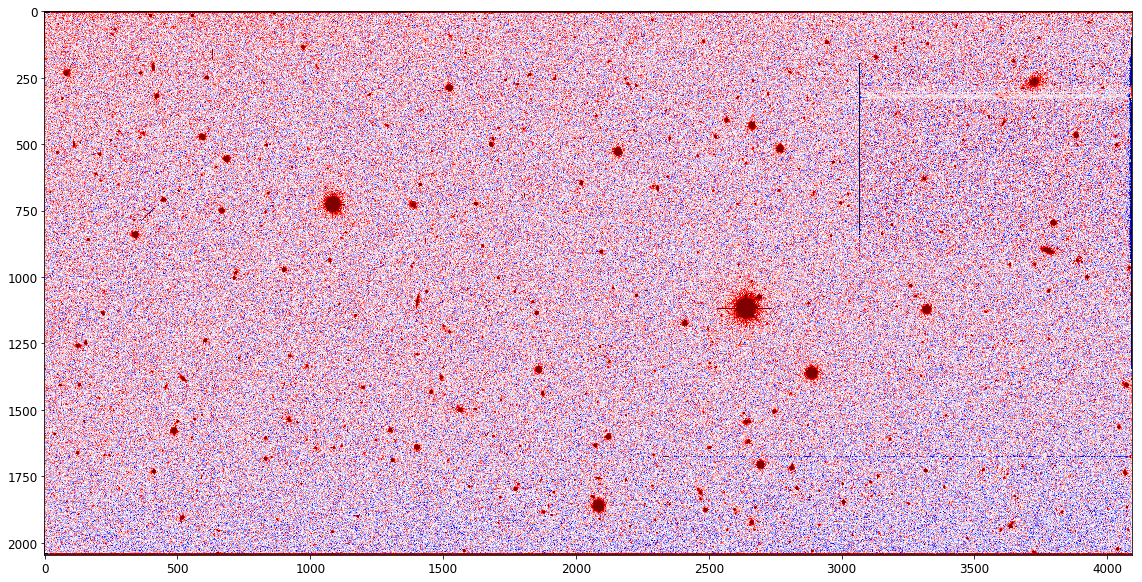

1767.641


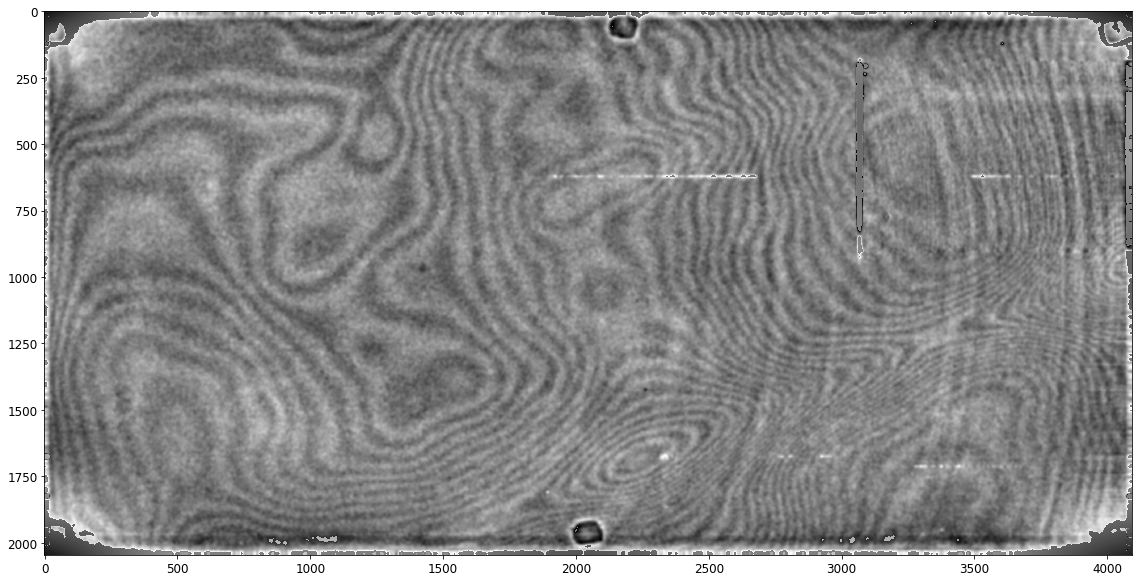

In [7]:
####################### Load CCD image #######################
# ccd_index = 0
ccd_index = len(ccd)//2
print(ccd_index)

img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index]).strip()
hdulist = fits.open(img_fn)
img = hdulist[ccd['image_hdu'][ccd_index]].data
frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']

# naive sky estimation
mask = (img<np.percentile(img.flatten(), 85))
sky = np.median(img[mask].flatten())
vrange = 2*(sky - np.percentile(img.flatten(), 0.5))

# # pad the edges with zeros to match the fringe image dimension
# img = np.pad(img, ((1, 1), (1, 1)), mode='constant', constant_values=0)

plt.figure(figsize=(20, 10))
plt.imshow(img.T, cmap='seismic', vmin=sky-vrange, vmax=sky+vrange)
plt.show()

####################### Load fringe image #######################
print(frgscale)
ccdnum = str(ccdnamenumdict[ccd[ccd_index]['ccdname'].strip()]).zfill(2)
fringe_path = os.path.join(fringe_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(ccdnum))
# fringe_path = os.path.join(fringe_dir, (hdulist[ccd['image_hdu'][ccd_index]].header)['FRINGE']+'.fits')
fringe = fits.getdata(fringe_path)
# remove the edge pixels
fringe = fringe[1:4095, 1:2047]

plt.figure(figsize=(20, 10))
plt.imshow(fringe.T, cmap='gray')
plt.show()

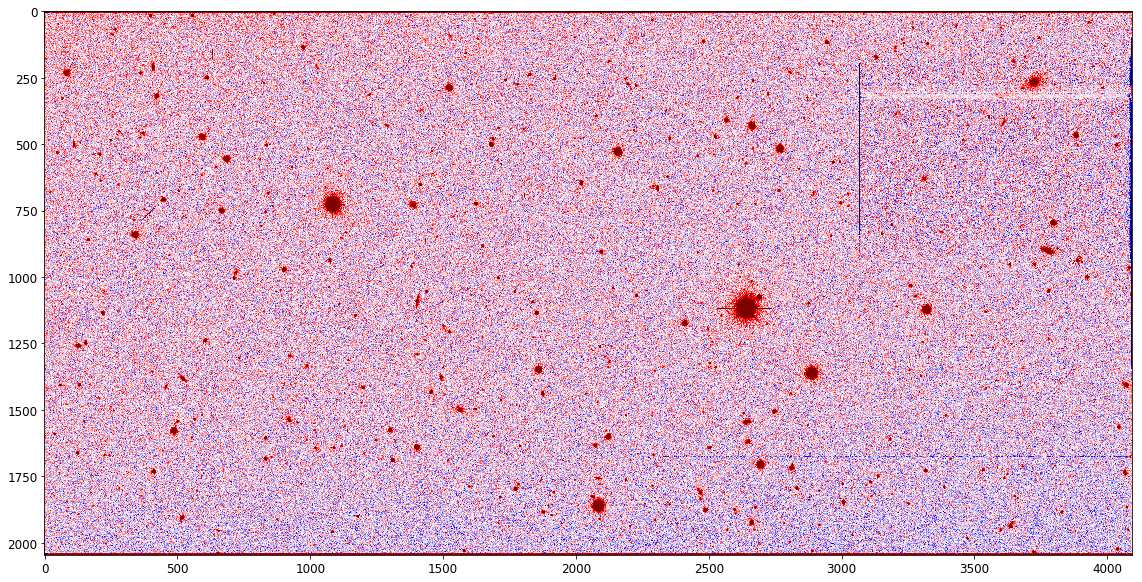

In [8]:
img_orig = img + fringe*frgscale

plt.figure(figsize=(20, 10))
plt.imshow(img_orig.T, cmap='seismic', vmin=sky-vrange, vmax=sky+vrange)
plt.show()